<a href="https://colab.research.google.com/github/AlexNoonan-Syracuse/Lab6/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
from google.colab import files

uploaded = files.upload()


Saving Zip_Zhvi_SingleFamilyResidence.csv to Zip_Zhvi_SingleFamilyResidence.csv


In [2]:
import io
import numpy as np


df1 = pd.read_csv(io.StringIO(uploaded['Zip_Zhvi_SingleFamilyResidence.csv'].decode('utf-8')))

print(df1.head())
print(df1.isna().sum())
print(df1.columns)
#print(df1.describe)

   RegionID  SizeRank  RegionName  ... 2020-01-31 2020-02-29 2020-03-31
0     61639         0       10025  ...  1381453.0  1385737.0  1389268.0
1     84654         1       60657  ...   972038.0   973671.0   975642.0
2     61637         2       10023  ...  1478980.0  1479301.0  1474994.0
3     91982         3       77494  ...   335860.0   336037.0   336483.0
4     84616         4       60614  ...  1198277.0  1199900.0  1200980.0

[5 rows x 300 columns]
RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
             ..
2019-11-30    0
2019-12-31    0
2020-01-31    0
2020-02-29    0
2020-03-31    0
Length: 300, dtype: int64
Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '1996-01-31',
       ...
       '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
       '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31'],
      dtype='object', length=300)


In [3]:
# time series of Hot Springs, Little Rock, Fayetteville, Searcy 
# Present all values from 1997 to present 
# Average at the metro area level

# reshape dataframe on
metro_areas = ['Hot Springs', 'Little Rock', 'Fayetteville', 'Searcy']

dfAr =  df1[df1['State']=="AR"]
dfAr = dfAr[dfAr['City'].isin(metro_areas)]

# removing 1996 columns
dfAr = dfAr[dfAr.columns.drop(list(dfAr.filter(regex='1996-')))]
dfAr.reset_index(inplace=True)
dfAr = dfAr.drop(columns=['index','RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName','State', 'City', 'CountyName'])

dfAr['Metro'] = dfAr['Metro'].str.replace('Fayetteville-Springdale-Rogers', 'Fayetteville')
dfAr['Metro'] = dfAr['Metro'].str.replace('Little Rock-North Little Rock-Conway', 'Little Rock')
print(dfAr.head())

# aggregating averages across the metros and dates
dfAr_avg = dfAr.groupby('Metro').mean()

# pivoting on dates

# list of date columns
dateCols = list(dfAr_avg.filter(regex='-'))
list(dfAr_avg.index)

          Metro  1997-01-31  1997-02-28  ...  2020-01-31  2020-02-29  2020-03-31
0   Hot Springs     90258.0     91196.0  ...    163134.0    164485.0    166238.0
1  Fayetteville     96387.0     96430.0  ...    228725.0    229374.0    229775.0
2  Fayetteville    115676.0    116224.0  ...    242717.0    243144.0    243194.0
3        Searcy     76281.0     76540.0  ...    137024.0    136435.0    136386.0
4   Little Rock     51753.0     51946.0  ...     75124.0     76106.0     76895.0

[5 rows x 280 columns]


['Fayetteville', 'Hot Springs', 'Little Rock', 'Searcy']

In [36]:
# reshaping dfAr index = columnames, value = dates, column = metro
from datetime import datetime
dfArFinal = pd.melt(dfAr, id_vars=dateCols, value_vars='Metro' )
dfArFinal = dfArFinal.groupby('value').mean()
dfArFinal.reset_index(inplace=True)
dfArFinal.rename(columns={'value':'Metro'}, inplace=True)

dfArFinal = pd.melt(dfArFinal, id_vars='Metro', value_vars=dateCols )
dfArFinal.rename(columns={'value':'Avg', 'variable':'Date'}, inplace=True)
dfArFinal['Date'] = pd.to_datetime(dfArFinal['Date'], infer_datetime_format=True)
dfArFinal.set_index('Date', inplace=True)
print(dfArFinal)


                   Metro            Avg
Date                                   
1997-01-31  Fayetteville  106636.000000
1997-01-31   Hot Springs   73681.500000
1997-01-31   Little Rock  105411.583333
1997-01-31        Searcy   64932.000000
1997-02-28  Fayetteville  107094.333333
...                  ...            ...
2020-02-29        Searcy  104397.500000
2020-03-31  Fayetteville  228817.000000
2020-03-31   Hot Springs  147991.500000
2020-03-31   Little Rock  184211.615385
2020-03-31        Searcy  104423.000000

[1116 rows x 2 columns]


Metro     object
Avg      float64
dtype: object

TypeError: ignored

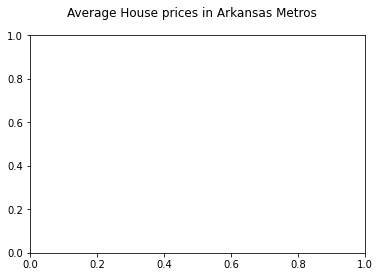

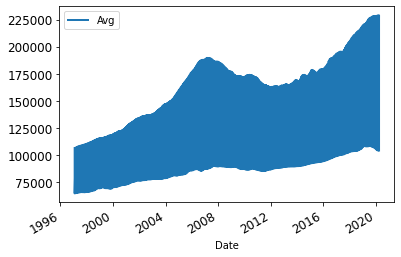

In [50]:
# time series plots of Avg price over time
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
fig.suptitle('Average House prices in Arkansas Metros')

ax[] = dfArFinal.plot(l  linewidth=2, fontsize=12)

# Additional customizations
ax.set_xlabel('Date')
ax.legend(fontsize=12)
#for i in range(len(metro_areas)):
 #   print(i)
  #  plotDf = dfArFinal[dfArFinal['Metro'] == metro_areas[i]]
   # print(plotDf)
    #axs[i].plot(plotDf.index, plotDf.Avg)


#plt.show()